# Knowledge graph disease node embeddings with Word2Vec

A major step in the rare disease clustering process is to embed the disease nodes into a vector space upon which clustering algorithms can operate. Here we follow the approaches that have bee pioneered by other methods such as [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf), [Node2Vec](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf) and [DL2Vec](https://academic.oup.com/bioinformatics/article/37/6/853/5922810). One question that is partially addressed in the Node2Vec paper, but not in the others is how big should the vector embedding dimension be? This question is difficult to address because the clustering models derived from embeddings of different dimensions cannot be directly compared using internal cluster validation statistics such as the silhouette score, davies-bouldin score or calinski-harabarz index, because all of those rely on distance metrics which are sensitive to dimensionality. 

While limited guidance exists on how to set the embedding dimension in an unsupervised setting a couple of sources point us in the right direction. This Google Developers blog suggests that they use a rule of thumb as the 4th root of the number of vocabulary size (1)[https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html]. The Node2Vec authors performed an experiment using their datasets that suggest that there are diminishing returns on increasing the embedding dimension around the range of 64 to 256; however this is likely to be corpus dependent.

Here I take a look at my graph and my random walk file to assess what the 4th root rule of thumbe would suggest. Then I construct an embedding model in a range that aligns with that suggestion and perform PCA to assess the effective dimensionality of the embedding model. 

In [1]:
import pickle
from sklearn import decomposition
import networkx as nx
import gensim

import matplotlib.pyplot as plt
%matplotlib inline

## Load the knowledge graph

In [2]:
with open('../data/processed/disease_ontograph.pkl', 'rb') as f:
    disease_ontograph = pickle.load(f)

#Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

#Extract diseases
diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

## What does a sentence look like in the random walk file?

In [3]:
sentences=gensim.models.word2vec.LineSentence("../data/walks/walks_N250_L250.txt")
next(sentences.__iter__())

['GARD:0002198',
 'associated_with',
 '23474',
 'interacts-with',
 '5621',
 'interacts-with',
 '55684',
 'chemical-affects',
 'CHEMBL:CHEMBL108',
 'chemical-affects',
 '221806',
 'chemical-affects',
 'CHEMBL:CHEMBL108',
 'chemical-affects',
 '5457',
 'associated_with',
 'GO:0048665',
 'is_a',
 'GO:0001708',
 'is_a',
 'GO:0010158',
 'is_a',
 'GO:0001708',
 'is_a',
 'GO:0048665',
 'associated_with',
 '63950',
 'associated_with',
 'GO:0035914',
 'associated_with',
 '10362',
 'in-complex-with',
 '55758',
 'interacts-with',
 '130026',
 'chemical-affects',
 'PUBCHEM:6044',
 'chemical-affects',
 '6750',
 'associated_with',
 'GO:0008628',
 'associated_with',
 '5741',
 'in-complex-with',
 '2792',
 'in-complex-with',
 '3763',
 'controls-state-change-of',
 '2913',
 'in-complex-with',
 '5154',
 'controls-state-change-of',
 '3071',
 'controls-state-change-of',
 '23396',
 'associated_with',
 'GO:0005654',
 'associated_with',
 '5698',
 'chemical-affects',
 'PUBCHEM:84691',
 'chemical-affects',
 '8346

## What would the rule of thumb suggest for the embedding dimension?

Using the whole graph, the rule of thumb would suggest using an embedding dimensions of 26. However, it is also reccomended to use a power of 2 for model training performance, therefore we're likely in the range of 16, 32 or 64. 

In [4]:
sentences=gensim.models.word2vec.LineSentence("../data/walks/walks_N250_L250.txt")

In [7]:
model = gensim.models.Word2Vec.load("../data/embeddings/ontograph_embed_N250_L250_D32_K20.model")

In [8]:
#4th root rule of thumb
print("Based on the knowledge graph: {0}".format(disease_ontograph.number_of_nodes()**0.25))
print("Based on the walk file corpus: {0}".format(model.corpus_count**0.25))

Based on the knowledge graph: 25.750572802369348
Based on the walk file corpus: 30.00462855834183


In [9]:
disease_ontograph.number_of_edges()

2716895

In [10]:
disease_ontograph.number_of_nodes()

439691

## Effective dimenionality of the disease node vectors only

We only really care about the effective dimensionality of the disease node vectors since those are what we plan to cluster. To assess this, I perform a PCA analysis and we can see there is a clear drop off in variance explained around the 28th vector, with the final vector explaining 2 orders of magnitude less than the first vector. I believe this suggests that the 32 dimensional vector is sufficiently complext to capture the principal axes of variation of the disease nodes.

In [11]:
disease_vectors = model.wv[diseases]
pca = decomposition.PCA()
pca.fit(disease_vectors)
pca_disease = pca.fit_transform(disease_vectors)

In [12]:
pca.explained_variance_

array([0.5264306 , 0.29563648, 0.20380086, 0.12595877, 0.11554061,
       0.10419273, 0.09668162, 0.08929157, 0.0872839 , 0.08607887,
       0.07775637, 0.07593037, 0.07109445, 0.06772719, 0.06523041,
       0.06460371, 0.06340517, 0.06047558, 0.05817171, 0.05535883,
       0.05094792, 0.04953381, 0.04845836, 0.04730572, 0.04462529,
       0.04240469, 0.03807726, 0.03138294, 0.02817267, 0.02071914,
       0.00891805, 0.0029153 ], dtype=float32)

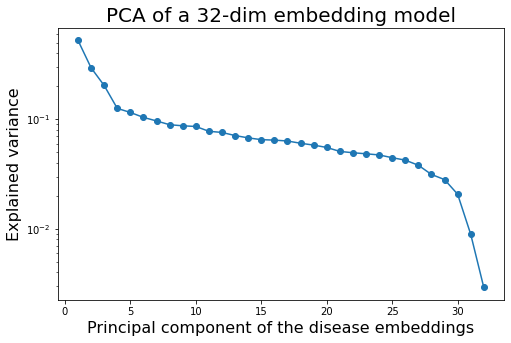

In [13]:
plt.figure(figsize=(8,5), facecolor='white', edgecolor='k')
plt.plot([i+1 for i in range(32)],pca.explained_variance_,marker="o")
plt.yscale('log')
plt.title("PCA of a 32-dim embedding model",size=20)
plt.xlabel("Principal component of the disease embeddings",size=16)
plt.ylabel("Explained variance",size=16)
plt.show()